In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


In [3]:
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 5)

# Load dataset
path = 'D:\Projects\steel-energy-mlops\data\clean\steel_energy_cleaned.csv'
df = pd.read_csv(path)

print(f"Rows: {df.shape[0]} | Columns: {df.shape[1]}")

# Asegurar tipado correcto de 'date' (era object)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

df.head()

Rows: 32608 | Columns: 11


<>:5: SyntaxWarning: invalid escape sequence '\P'
<>:5: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Angel\AppData\Local\Temp\ipykernel_33220\4233829968.py:5: SyntaxWarning: invalid escape sequence '\P'
  path = 'D:\Projects\steel-energy-mlops\data\clean\steel_energy_cleaned.csv'


,date,usage_kwh,lagging_current_reactive.power_kvarh,leading_current_reactive_power_kvarh,co2(tco2),lagging_current_power_factor,leading_current_power_factor,nsm,weekstatus,day_of_week,load_type
0,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800.0,Weekday,Monday,Light_load
1,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,Weekday,Monday,Light_load
2,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,Weekday,Monday,Light_load
3,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500.0,Weekday,Monday,Light_load
4,2018-01-01 01:30:00,3.28,3.56,0.0,0.0,67.76,100.0,5400.0,Weekday,Monday,Light_load


In [9]:
df['hour'] = df['date'].dt.hour
df['dayofweek_num'] = df['date'].dt.dayofweek  # 0=Mon,...,6=Sun
df['month'] = df['date'].dt.month

In [10]:
df = pd.get_dummies(df, columns=['weekstatus', 'day_of_week', 'load_type'], drop_first=True)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32608 entries, 0 to 32607
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  12085 non-null  datetime64[ns]
 1   usage_kwh                             32608 non-null  float64       
 2   lagging_current_reactive.power_kvarh  32608 non-null  float64       
 3   leading_current_reactive_power_kvarh  32608 non-null  float64       
 4   co2(tco2)                             32608 non-null  float64       
 5   lagging_current_power_factor          32608 non-null  float64       
 6   leading_current_power_factor          32608 non-null  float64       
 7   nsm                                   32608 non-null  float64       
 8   dayofweek_num                         12085 non-null  float64       
 9   hour                                  12085 non-null  float64       
 10

✅ Column names aligned with model features.



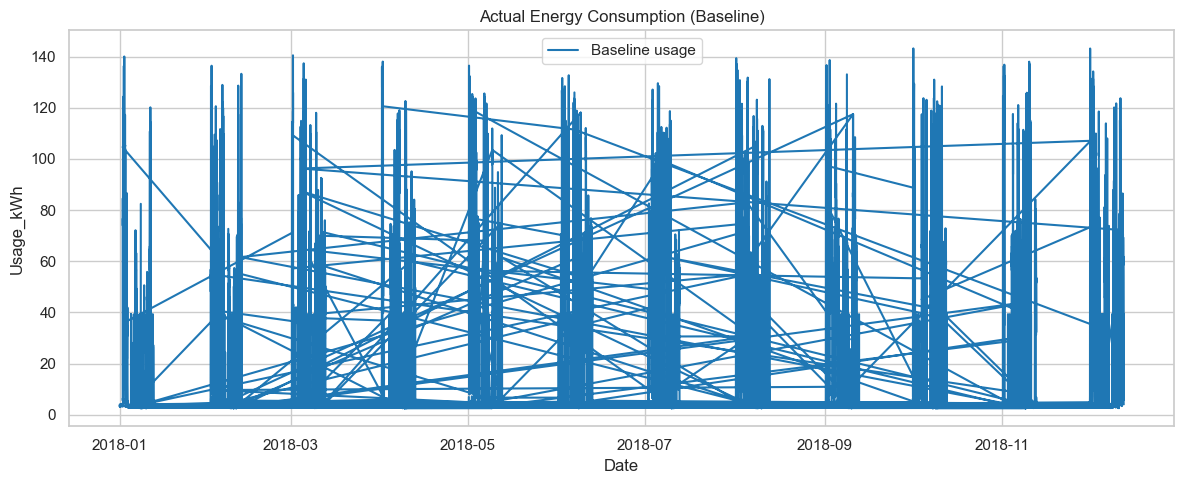

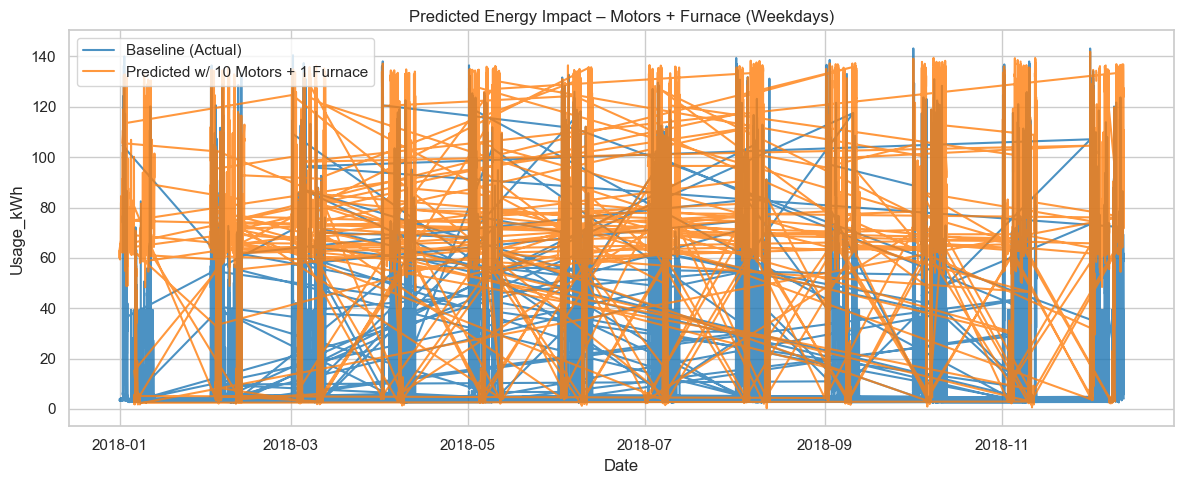

Baseline total energy:      902,954.6 kWh
Predicted w/ additions:     1,408,439.9 kWh
Estimated increase:         55.98%



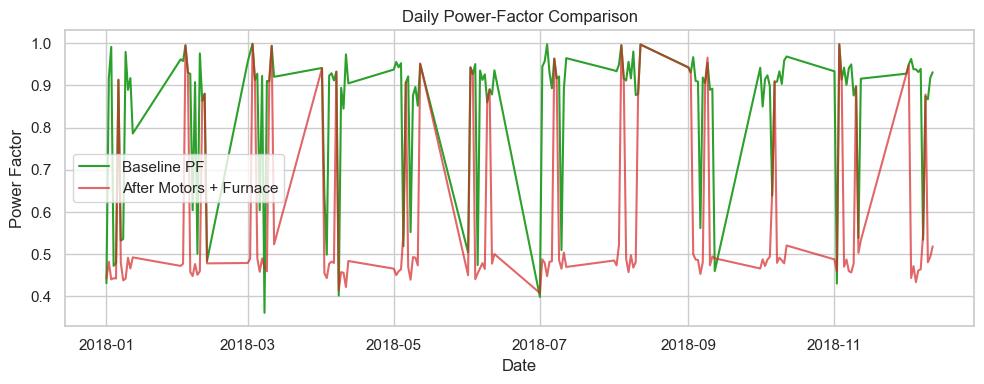

In [18]:
# -----------------------------------------------------------
#  Energy-impact simulation using XGB_model_V0M0.pkl
#  Adds 10×20 HP motors + 1 furnace, predicts new usage
# -----------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

# -----------------------------------------------------------
# 1. Load model and data
# -----------------------------------------------------------
xgb_model = joblib.load("XGB_model_V0M0.pkl")

# Assume df already loaded, e.g.:
# df = pd.read_csv("your_dataset.csv", parse_dates=["date"])

# Clean and normalize column names
df.columns = df.columns.str.strip()

# -----------------------------------------------------------
# 2. Ensure all required columns exist
# -----------------------------------------------------------
if "dayofweek_num" not in df.columns:
    df["dayofweek_num"] = df["date"].dt.dayofweek  # 0=Mon … 6=Sun

# -----------------------------------------------------------
# 3. Align DataFrame column names to the model's expectations
# -----------------------------------------------------------
rename_map = {
    "load_type_maximum_load": "load_type_Maximum_load",
    "load_type_medium_load": "load_type_Medium_load",
    "weekstatus_weekend": "weekstatus_Weekend"
}
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

# -----------------------------------------------------------
# 4. Confirm feature alignment
# -----------------------------------------------------------
features = [
    "lagging_current_reactive.power_kvarh",
    "leading_current_reactive_power_kvarh",
    "lagging_current_power_factor",
    "leading_current_power_factor",
    "nsm",
    "hour",
    "dayofweek_num",
    "month",
    "weekstatus_Weekend",
    "load_type_Maximum_load",
    "load_type_Medium_load",
]

missing = [f for f in features if f not in df.columns]
if missing:
    raise ValueError(f"⚠️ Missing columns in df: {missing}")

print("✅ Column names aligned with model features.\n")

# -----------------------------------------------------------
# 5. Plot baseline usage
# -----------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(df["date"], df["usage_kwh"], label="Baseline usage", color="tab:blue")
plt.title("Actual Energy Consumption (Baseline)")
plt.xlabel("Date")
plt.ylabel("Usage_kWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 6. Simulate addition of 10 motors + 1 furnace (Mon–Fri all day)
# -----------------------------------------------------------
df_sim = df.copy()
is_weekday = df_sim["dayofweek_num"] < 5  # Monday–Friday

# Furnace & motors per-15-min additions (divide by 4 if hourly figures)
add_kwh = 700 / 4           # furnace energy per 15 min
add_kvarh_motors = 17.9     # 10 motors combined
add_kvarh_furnace = 525 / 4 # furnace reactive energy per 15 min
add_lagging_kvarh = add_kvarh_motors + add_kvarh_furnace

df_sim.loc[is_weekday, "usage_kwh"] += add_kwh
df_sim.loc[is_weekday, "lagging_current_reactive.power_kvarh"] += add_lagging_kvarh

# Optional: switch load-type flags
if "load_type_Maximum_load" in df_sim.columns:
    df_sim.loc[is_weekday, "load_type_Maximum_load"] = True
if "load_type_Medium_load" in df_sim.columns:
    df_sim.loc[is_weekday, "load_type_Medium_load"] = False

# -----------------------------------------------------------
# 7. Predict usage with the model
# -----------------------------------------------------------
predicted_usage = xgb_model.predict(df_sim[features])
df_sim["Predicted_Usage_kWh"] = predicted_usage

# -----------------------------------------------------------
# 8. Plot baseline vs predicted
# -----------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(df["date"], df["usage_kwh"], label="Baseline (Actual)", color="tab:blue", alpha=0.8)
plt.plot(df_sim["date"], df_sim["Predicted_Usage_kWh"],
         label="Predicted w/ 10 Motors + 1 Furnace", color="tab:orange", alpha=0.8)
plt.title("Predicted Energy Impact – Motors + Furnace (Weekdays)")
plt.xlabel("Date")
plt.ylabel("Usage_kWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 9. Summary table
# -----------------------------------------------------------
baseline_total = df["usage_kwh"].sum()
predicted_total = df_sim["Predicted_Usage_kWh"].sum()
increase_pct = (predicted_total - baseline_total) / baseline_total * 100

print(f"Baseline total energy:      {baseline_total:,.1f} kWh")
print(f"Predicted w/ additions:     {predicted_total:,.1f} kWh")
print(f"Estimated increase:         {increase_pct:.2f}%\n")

# -----------------------------------------------------------
# 10. (Optional) Daily PF comparison
# -----------------------------------------------------------
df_pf = pd.DataFrame({
    "Date": df["date"].dt.date,
    "Baseline_Q": df["lagging_current_reactive.power_kvarh"] - df["leading_current_reactive_power_kvarh"],
    "Baseline_P": df["usage_kwh"],
    "New_Q": df_sim["lagging_current_reactive.power_kvarh"] - df_sim["leading_current_reactive_power_kvarh"],
    "New_P": df_sim["Predicted_Usage_kWh"],
})

df_pf = (
    df_pf.groupby("Date")
    .agg({"Baseline_P": "sum", "Baseline_Q": "sum", "New_P": "sum", "New_Q": "sum"})
    .reset_index()
)
df_pf["PF_Baseline"] = df_pf["Baseline_P"] / np.sqrt(df_pf["Baseline_P"]**2 + df_pf["Baseline_Q"]**2)
df_pf["PF_New"] = df_pf["New_P"] / np.sqrt(df_pf["New_P"]**2 + df_pf["New_Q"]**2)

plt.figure(figsize=(10, 4))
plt.plot(df_pf["Date"], df_pf["PF_Baseline"], label="Baseline PF", color="tab:green")
plt.plot(df_pf["Date"], df_pf["PF_New"], label="After Motors + Furnace", color="tab:red", alpha=0.7)
plt.title("Daily Power-Factor Comparison")
plt.xlabel("Date")
plt.ylabel("Power Factor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
